# Laboratorio 9 - Visualización Interactiva

### Cristian Laynez 201281
### Josué Sagastume 18173

## Paleta de colores seleccionada:
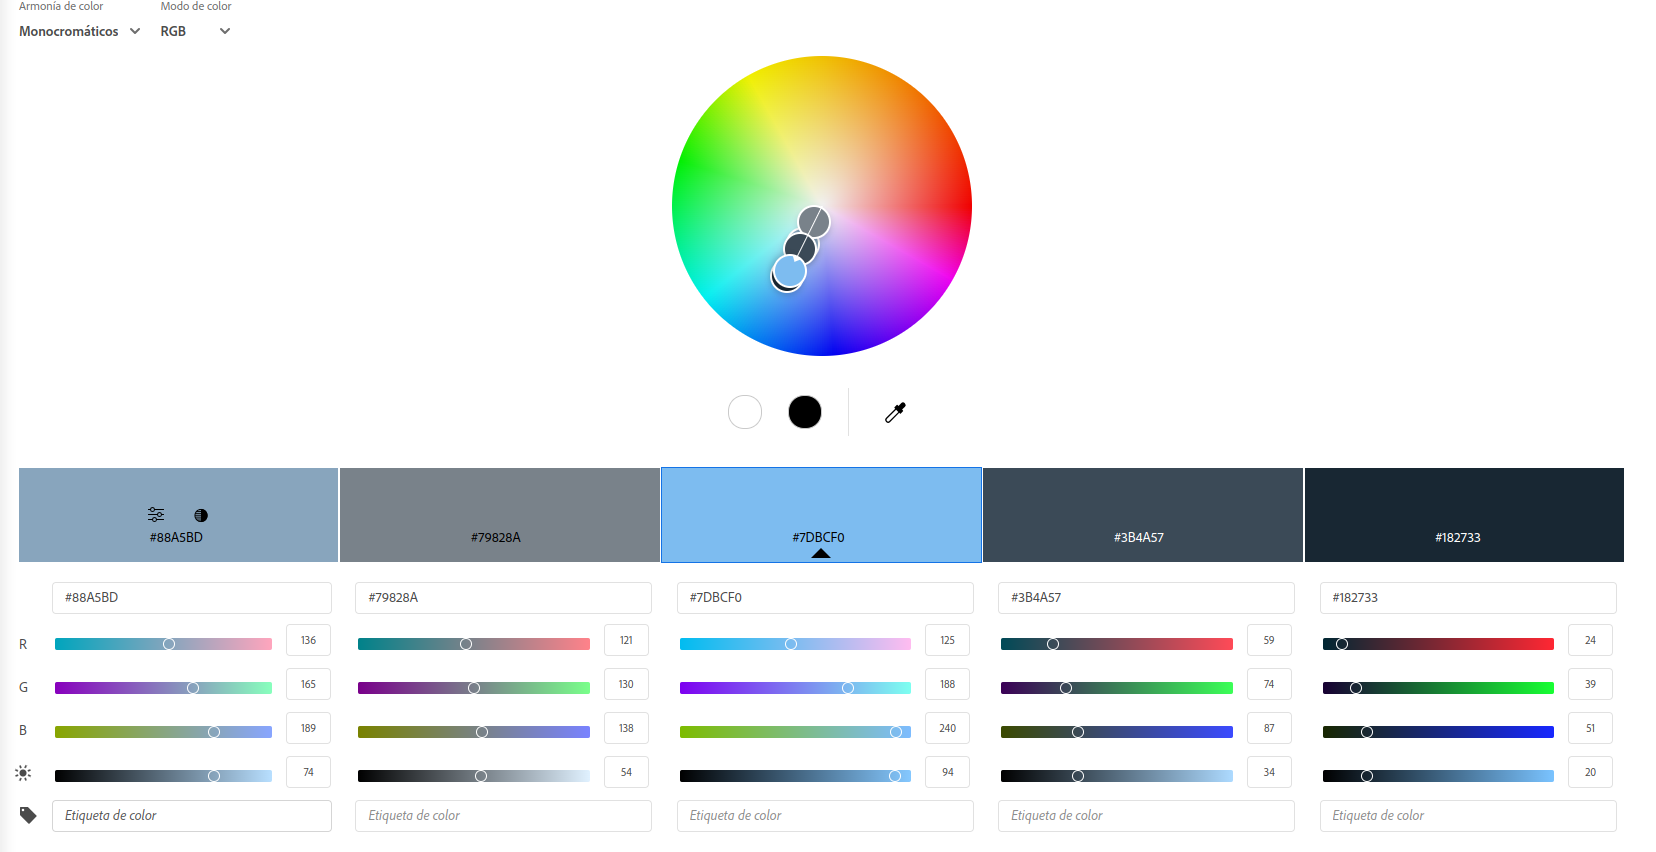

## Selección de la herramienta a utilizar:

Se utilizará Voilá.

Vamos a reutilizar el código del laboratorio 6 (ya que este fue el lab seleccionado para hacer la visualización)

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# Importar librerias
import pandas as pd
import nltk
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import ast

In [31]:
from nltk import bigrams
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [32]:
# Cargar data ya limpia extraida del laboratorio 6
data = pd.read_csv('./drive/Shareddrives/DataScience-DataSets/traficogt_clean.csv')

### Analisis exploratorio

In [33]:
# En los idiomas donde se habla del tráfico de Guatemala
lang_count = data["lang"].value_counts()
lang_count

es     11946
en       600
zxx       24
fr         9
qme        8
it         6
pt         6
ca         5
in         4
lt         4
qht        3
ja         3
ar         2
art        2
ko         2
eu         2
ru         1
et         1
de         1
tr         1
th         1
Name: lang, dtype: int64

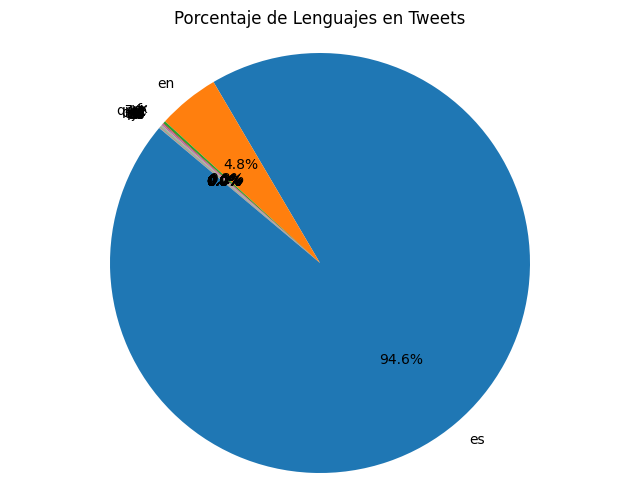

In [34]:
plt.figure(figsize=(8, 6))
plt.pie(lang_count, labels=lang_count.index, autopct='%1.1f%%', startangle=140)
plt.title('Porcentaje de Lenguajes en Tweets')
plt.axis('equal')

plt.show()

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12631 entries, 0 to 12630
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            12631 non-null  object 
 1   lang            12631 non-null  object 
 2   rawContent      12603 non-null  object 
 3   replyCount      12631 non-null  int64  
 4   retweetCount    12631 non-null  int64  
 5   likeCount       12631 non-null  int64  
 6   quoteCount      12631 non-null  int64  
 7   hashtags        12631 non-null  object 
 8   viewCount       12631 non-null  float64
 9   place           12631 non-null  object 
 10  sourceLabel     12631 non-null  object 
 11  username        12631 non-null  object 
 12  rawDescription  12406 non-null  object 
 13  year            12631 non-null  int64  
dtypes: float64(1), int64(5), object(8)
memory usage: 1.3+ MB


In [36]:
import ipywidgets as widgets
import pandas as pd

In [37]:
selector_columna = widgets.Dropdown(
    options=data.columns,
    description='Columna:',
    disabled=False,
)

In [38]:
def mostrar_datos(columna):
    return data[columna].value_counts().head(10)

In [39]:
widgets.interactive(mostrar_datos, columna=selector_columna)

interactive(children=(Dropdown(description='Columna:', options=('date', 'lang', 'rawContent', 'replyCount', 'r…

### Modelos de machine learning

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import plotly.express as px

In [41]:
X = data[['replyCount', 'retweetCount', 'quoteCount']]
y = data['likeCount']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [43]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [44]:
def plot_feature(columna):
    fig = px.histogram(data, x=columna)
    fig.show()

In [45]:
widgets.interactive(plot_feature, columna=selector_columna)

interactive(children=(Dropdown(description='Columna:', options=('date', 'lang', 'rawContent', 'replyCount', 'r…